# Mnist

In [9]:
import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline

In [10]:
# 超参数定义
EPOCH = 1
BATCH_SIZE = 64
TIME_STEP = 28
INPUT_SIZE = 28
LR = 0.001

In [11]:
# MNIST数据集下载
train_data = datasets.MNIST(root='../resource', train=True, 
                            transform=transforms.ToTensor(),
                            download = True
                           )
test_data = datasets.MNIST(root='../resource', train=False, 
                            transform=transforms.ToTensor(),
                            download = True
                           )


In [12]:
test_x = test_data.test_data.type(torch.FloatTensor)[:2000] / 255.
test_y = test_data.test_labels.numpy()[:2000]

torch.Size([60000, 28, 28])
torch.Size([60000])


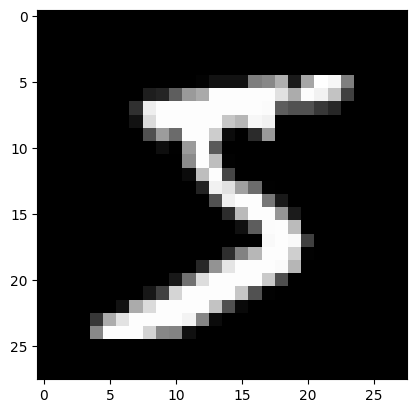

In [13]:
print(train_data.train_data.size())
print(train_data.train_labels.size())
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.show()
#print(train_data)

In [14]:
# 使用Dataloader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


In [15]:
# 定义网络
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.GRU(input_size=INPUT_SIZE, hidden_size=64, num_layers=1, batch_first=True)
        self.out = nn.Linear(64, 10) #10个分类

    def forward(self, x):
        # 前向传播
        r_out, _ = self.rnn(x)
        # 选择 r_out的最后一个时间步
        out = self.out(r_out[:,-1,:])
        return out

In [ ]:
# 设置使用GPU
cuda = torch.device('cuda')
rnn = RNN()
rnn = rnn.cuda()
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [ ]:
# 训练&验证
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):
        b_x = b_x.view(-1, 28, 28)
        # 前向传播
        output = rnn(b_x.cuda())
        # 损失函数
        loss = loss_func(output, b_y.cuda())
        # 后向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            test_output = rnn(test_x.cuda())
            pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()
            # 计算准确率
            accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
            print ('Epoch: {}, Step: {}, loss: {}, accuracy: {}'.format(epoch, step, loss, accuracy))

In [ ]:
# 从测试集选出10个，进行验证
test_x = test_x.cuda()
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()
print('预测数字', pred_y)
print('实际数字', test_y[:10])